In [1]:
import matplotlib.pyplot as plt
import sklearn.linear_model
import urllib.request
import pandas as pd
import numpy as np
import os

from sklearn.neighbors import KNeighborsRegressor
from pathlib import Path

In [2]:
# URLS
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
# PATHS
DATASET_PATH = Path("..", "Datasets", "lifesat", "")

In [3]:
def prepare_country_stats(oecd_bli, gdp_per_capita):
    # ====== OECD_BLI ====== #
    # oecd_bli contain many indicators and groups for the same country, since we want to check only one, some filters are necessary
    # First, filter total inequality (Other measurements would be men as MN and woman as WMN)
    oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
    # Second, create a new table:
    #    - Indexed by Country (each row is a diferent country);
    #    - Columns based on each possible value for "Indicator";
    #    - Values on the new table representing the column "Value" on the original table;
    oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
    
    # ====== GDP_PER_CAPITA ====== #
    # Renaming column "2015" to "GDP per capita"
    gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
    # Setting "Country" as the index instead of it being numerical (numerical can still be used with iloc)
    gdp_per_capita.set_index("Country", inplace=True)
    
    # ====== MERGING TABLES ====== #
    # Inner join on oecd_bli.index = gdp_per_capita.index (that's why we set country as the index in both tables)
    full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita,
                                  left_index=True, right_index=True)
    # Sort the merge table by gdp per capita
    full_country_stats.sort_values(by="GDP per capita", inplace=True)
    # Author removes some countries that are outliers and may hamper linearity visualisation for the data
    remove_indices = [0, 1, 6, 8, 33, 34, 35]
    keep_indices = list(set(range(36)) - set(remove_indices))
    return full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices]

In [4]:
# Prepare destination folder
os.makedirs(DATASET_PATH, exist_ok=True)
# Download data
for filename in ("oecd_bli_2015.csv", "gdp_per_capita.csv"):
    print("Downloading", filename)
    # Check if the download is necessary
    if Path(DATASET_PATH, filename).is_file():
        print("Skipping... File already exists")
        continue
    # Downloading the data
    url = DOWNLOAD_ROOT + "datasets/lifesat/" + filename
    urllib.request.urlretrieve(url, DATASET_PATH / filename)


Skipping... File already exists
Skipping... File already exists


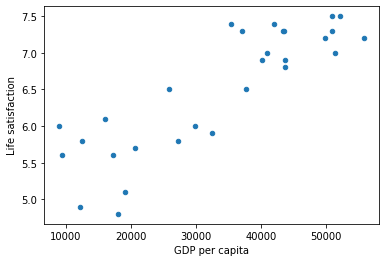

[[5.96242338]]


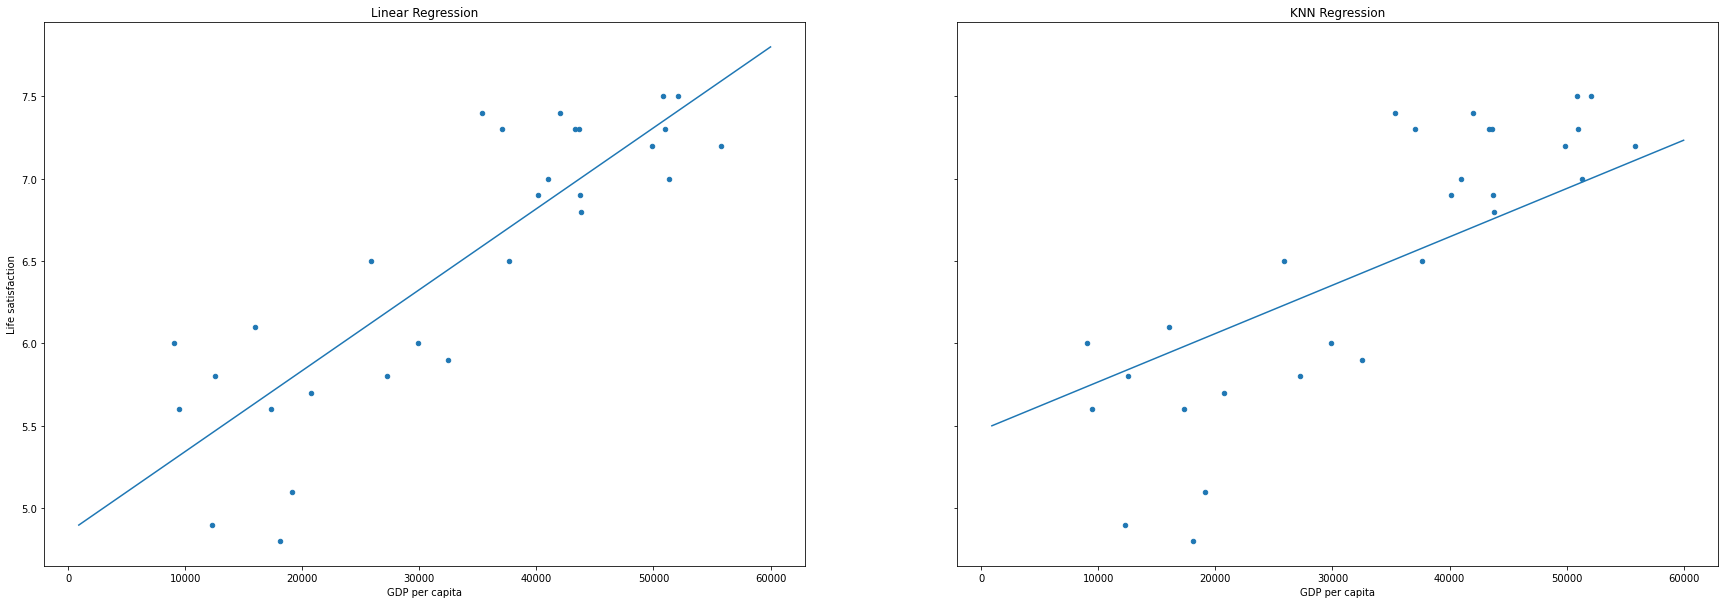

In [5]:
# Load the data
oecd_bli = pd.read_csv(DATASET_PATH / "oecd_bli_2015.csv", thousands=',')
gdp_per_capita = pd.read_csv(DATASET_PATH / "gdp_per_capita.csv",thousands=',',delimiter='\t',
                             encoding='latin1', na_values="n/a")

# Prepare the data
country_stats = prepare_country_stats(oecd_bli, gdp_per_capita)
X = np.c_[country_stats["GDP per capita"]]
y = np.c_[country_stats["Life satisfaction"]]

# Visualize the data
country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction')
plt.show()

# ====== Linear Regression ====== #
linear_model = sklearn.linear_model.LinearRegression()
# Train the models
linear_model.fit(X, y)

# ====== KNN Regression ====== #
knn_model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=3)
# Train the models
knn_model.fit(X, y)

# Make a prediction for Cyprus
X_new = [[22587]]  # Cyprus' GDP per capita
print(linear_model.predict(X_new)) # outputs [[ 5.96242338]]

# Point to draw the prediction line
x = [900, 60000]
lin_pred = [linear_model.predict([[value]])[0][0] for value in x]
knn_pred = [knn_model.predict([[value]])[0][0] for value in x]

# Plot axes and figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(30,10), sharey=True, sharex=True)

# Plot points and prediction on the left axis
ax1.set_title("Linear Regression")
country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', ax=ax1)
ax1.plot(x, lin_pred)

# Plot points and prediction on the right axis
ax2.set_title("KNN Regression")
country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', ax=ax2)
ax2.plot(x, knn_pred)

plt.show()

Index(['Air pollution', 'Assault rate', 'Consultation on rule-making',
       'Dwellings without basic facilities', 'Educational attainment',
       'Employees working very long hours', 'Employment rate', 'Homicide rate',
       'Household net adjusted disposable income',
       'Household net financial wealth', 'Housing expenditure', 'Job security',
       'Life expectancy', 'Life satisfaction', 'Long-term unemployment rate',
       'Personal earnings', 'Quality of support network', 'Rooms per person',
       'Self-reported health', 'Student skills',
       'Time devoted to leisure and personal care', 'Voter turnout',
       'Water quality', 'Years in education', 'Subject Descriptor', 'Units',
       'Scale', 'Country/Series-specific Notes', 'GDP per capita',
       'Estimates Start After'],
      dtype='object')
Country
Estonia             9.0
Sweden             10.0
New Zealand        11.0
France             12.0
Luxembourg         12.0
Ireland            13.0
Slovak Republic    13.

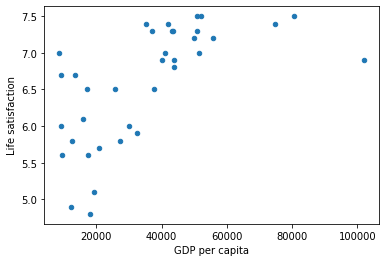

In [6]:
# Test code - Understanding why the autor dropped some values before the regression

result = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
result = result.pivot(index="Country", columns="Indicator", values="Value")

# Full Country Stats (fcs)
fcs = pd.merge( left=result, right=gdp_per_capita,
                left_index=True, right_index=True)
fcs.sort_values(by="GDP per capita", inplace=True)
fcs[["GDP per capita", 'Life satisfaction']].plot.scatter(x='GDP per capita', y='Life satisfaction')

print(fcs.columns)
print(fcs['Air pollution'].sort_values())